# Classification and Regression 3

This session explores ensemble methods Random Forest (RF) and Gradient-Boosted Decision Trees (GBDTs).

Learning Outcomes:
- Apply RFs and GBDTs in a multi-group classification setting
- Explore differences in model performance based on changing model parameters
- Visualise the important variables 
- Apply RFs and GBDTs in a regression setting and explore the results

In [1]:
# IMPORTS 
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.manifold import MDS 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, f1_score, accuracy_score, balanced_accuracy_score, classification_report
import xgboost as xgb
import sklearn

## Import Dataset and Preprocessing

We will follow the steps from the ClassificationRegression2 tutorial for loading, scaling, and splitting the data in preparation for inputing to the models.

In [2]:
cancer_microbiome_genus = pd.read_excel('../Data/cancer_microbiome_genus.xlsx')
cancer_microbiome_genus.cancer.value_counts()
cancer_microbiome_genus.adenomas_or_cancer.value_counts()

3    48
0    47
1    26
2    13
Name: adenomas_or_cancer, dtype: int64

In [3]:
# Scale the data with standard scaling (0 mean and unit variance)
cancer_microbiome_genus_scaled = StandardScaler().fit_transform(cancer_microbiome_genus.iloc[:, 4:])

# Create a dataframe with adenoma/carcinoma status and the scaled data
scaled_df = pd.DataFrame(cancer_microbiome_genus_scaled)
scaled_df['adenomas_or_cancer'] = cancer_microbiome_genus.adenomas_or_cancer

In [4]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_df.iloc[:,:-1], scaled_df.adenomas_or_cancer, test_size=0.3, random_state=8)

## Random Forest

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the `max_samples` parameter if `bootstrap=True` (default), otherwise the whole dataset is used to build each tree. Some other parameters, specific to Random Forests, that you can set to optimise the [`sklearn.ensemble.RandomForestClassifier()`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) are:
- `n_estimators`: the number of trees in the forest
- `criterion`: the function to measure the quality of the split, can be Gini inpurity, log_loss and entropy for the Shannon information gain, look at the specific formulas [here](https://scikit-learn.org/stable/modules/tree.html#tree-mathematical-formulation)
- `max_depth`: the maximum depth of the tree, ie how many nodes to be expanded until all leaves are pure or contain less that `min_samples_split`
- `min_samples_split`: the minimum number of samples required to split an internal node
- `min_samples_leaf`: the minimum number of samples required to be a leaf (terminal) node
- `oob_score`: whether to use out-of-bag samples to estimate the generalization score

Make sure to look at the [`RandomForestClassifier()`](https://scikit-learn.org/stable/modules/generate/sklearn.ensemble.RandomForestClassifier.html) object page for the rest of the parameters available. 

You can read more about Random Forests in the user guide [documentation](https://scikit-learn.org/stable/modules/ensemble.html#forest).

In [5]:
# define the classifier with default parameters

rf_default = RandomForestClassifier()
y_pred_default = rf_default.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred_default))
print('accuracy:', accuracy_score(y_test, y_pred_default))

              precision    recall  f1-score   support

           0       0.46      0.73      0.56        15
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00         9
           3       0.31      0.83      0.45         6

    accuracy                           0.39        41
   macro avg       0.19      0.39      0.25        41
weighted avg       0.21      0.39      0.27        41

accuracy: 0.3902439024390244


/home/mk218/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mk218/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mk218/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0    15
1    11
2     9
3     6
Name: adenomas_or_cancer, dtype: int64

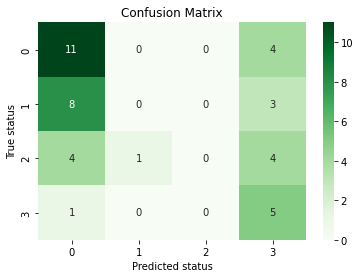

In [6]:
cm_default = confusion_matrix(y_test, y_pred_default)

def conf_matrix_heatmap(cm):
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Greens'); #annot=True to annotate cells
    ax.set_xlabel('Predicted status')
    ax.set_ylabel('True status')
    ax.set_title('Confusion Matrix')

conf_matrix_heatmap(cm_default)
display(y_test.value_counts()) # to see the class breakdown in the test-set 

Given what you see at the confusion matrix results on true and predicted status for each of the 4 classes, can you explain the zero division warning error we get when trying to calculate the precision and f1 score above?  

Now let's change the model parameters and see if we get a higher accuracy score...

In [7]:
rf = RandomForestClassifier(
    n_estimators=1000, 
    criterion='entropy', 
    oob_score=True, 
    class_weight='balanced'
)
y_pred = rf.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred))
print('accuracy:', accuracy_score(y_test, y_pred)) # if you want to look at extra decimals
print('oob score:', rf.oob_score_)

              precision    recall  f1-score   support

           0       0.39      0.60      0.47        15
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00         9
           3       0.28      0.83      0.42         6

    accuracy                           0.34        41
   macro avg       0.17      0.36      0.22        41
weighted avg       0.18      0.34      0.23        41

accuracy: 0.34146341463414637
oob score: 0.6451612903225806


/home/mk218/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mk218/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mk218/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Some questions to consider: 
- why did we use a balanced class weight? 
- what does the oob score tell us about the training set? 
- are more estimators (number of trees) always a good idea or is there a threshold? 

Have a go at tweaking the different parameters yourself!


### Feature Importance

Feature importances are provided by the fitted attribute `feature_importances_` and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree. Impurity-based feature importances can be misleading for high cardinality features (many unique values). For this reason we can use [`permutation feature importance`](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance). 

We will use the same cancer dataset but change our y target to the cancer column (0 - no cancer, 1 - cancer). 

In [8]:
# Create a dataframe with adenoma/carcinoma status and the scaled data
scaled_df = pd.DataFrame(cancer_microbiome_genus_scaled)
scaled_df['cancer'] = cancer_microbiome_genus.cancer

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_df.iloc[:,:-1], scaled_df.cancer, test_size=0.3, random_state=8)

# double check that the y is correct (since we are using same name variables)
display(y_train.value_counts())

0    51
1    42
Name: cancer, dtype: int64

In [9]:
# fit a new model 
rf = RandomForestClassifier(
    n_estimators=100, 
    criterion='gini', 
    oob_score=True
)
y_pred = rf.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred))
print('oob score:', rf.oob_score_)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        35
           1       0.67      0.67      0.67         6

    accuracy                           0.90        41
   macro avg       0.80      0.80      0.80        41
weighted avg       0.90      0.90      0.90        41

oob score: 0.7741935483870968


Below we will create a function that looks at the samples on the terminal nodes (leafs) and creates a proximity matrix. This matrix holds information on which samples have ended up together in the same leaf, for example when a pair of samples reach the same leaf in a tree their proximity value increases by one. We then normalise by dividing by the number of trees. We can then use multidimensional scaling, `MDS()` to visualise the sample separation.

In [10]:
def proximity_matrix(rf, X, normalise=True):      
    leafs = rf.apply(X)
    n_trees = leafs.shape[1]
    val = leafs[:,0]
    matrix = 1*np.equal.outer(val, val)
    for i in range(1, n_trees):
        val = leafs[:, i]
        matrix += 1*np.equal.outer(val, val)
    if normalise:
        matrix = matrix / n_trees
    return matrix

/home/mk218/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/manifold/_mds.py:517: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/home/mk218/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

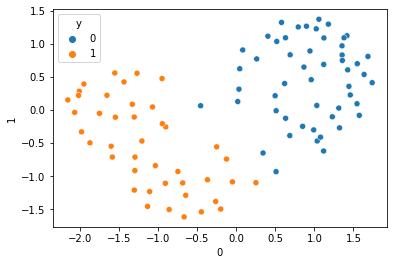

In [11]:
pm = proximity_matrix(rf, X_train, normalise=True)

df = pd.DataFrame(pm)
mds = MDS(n_components=2)
df_mds = MDS().fit_transform(X=df)
df_mds = pd.DataFrame(df_mds)
df_mds['y'] = y_train.tolist()

sns.scatterplot(df_mds[0], df_mds[1], data=df_mds, hue='y')

/home/mk218/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


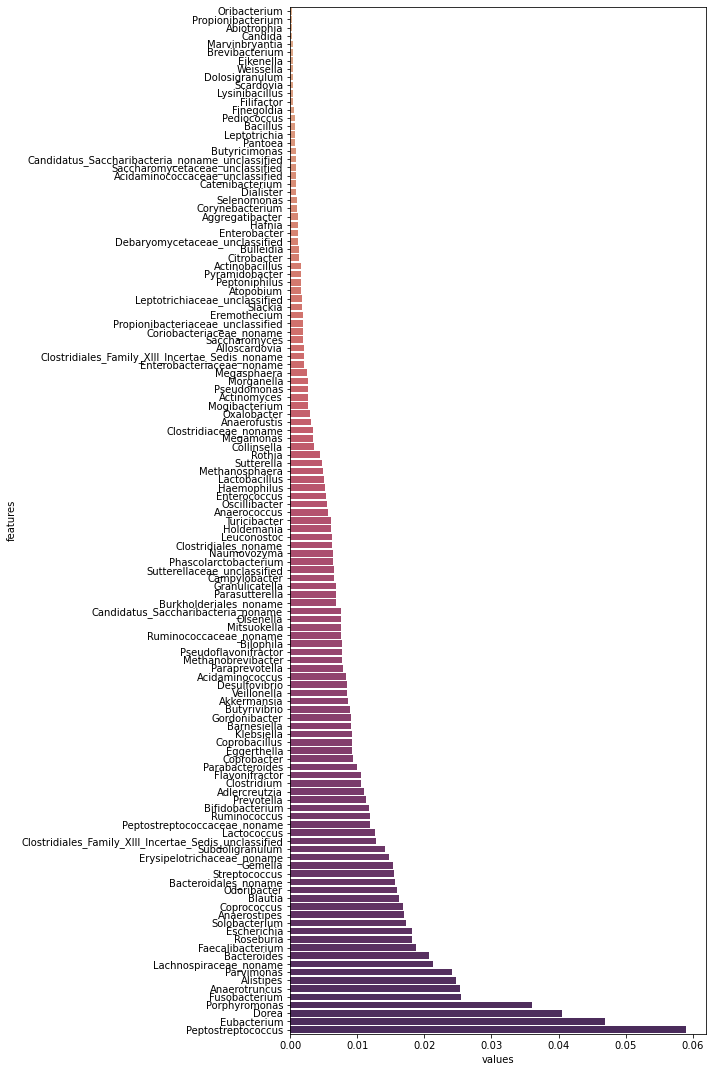

In [12]:
# look at feature importances 
feat_impo = rf.feature_importances_
features = cancer_microbiome_genus.columns[4:]

feature_dict = dict(zip(features, feat_impo))
bardf = pd.DataFrame(
        {'features': feature_dict.keys(),
         'values': feature_dict.values(),
        })
bardf = bardf.sort_values('values') # order values 
bardf = bardf[bardf['values'] != 0] # drop 0 value importance features
plt.figure(figsize=(10,15))
sns.barplot(bardf['values'], bardf['features'], data=bardf, palette = 'flare', order=bardf['features'], orient='h')
plt.tight_layout()


In [13]:
# we will use the same classifier for the permutation importance 
rf = RandomForestClassifier(
    n_estimators=100, 
    criterion='gini', 
    oob_score=True
).fit(X_train, y_train)
%time feat_impo_perm = permutation_importance(rf, X_train, y_train, n_repeats=10, random_state=0, scoring='accuracy')

# visaulise the new importance values similarly to how we did it above

CPU times: user 18.8 s, sys: 22.2 ms, total: 18.8 s
Wall time: 18.8 s


## Gradient Boosted Decision Trees

GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage `n_classes_` regression trees are fit on the negative gradient of the loss function, e.g. binary or multiclass log loss. Binary classification is a special case where only a single regression tree is induced. To explore GBDTs we will use the [`sklearn.ensemble.GradientBoostingClassifier()`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) object and the sklearn-supported [`xgboost.XGBClassifier()`](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier) object from the [`xgboost`](https://xgboost.readthedocs.io/en/stable/python/python_intro.html) package. To learn more about boosted trees take a look at the XGBoost [documentation](https://xgboost.readthedocs.io/en/stable/tutorials/model.html).

For the `xgboost.XGBClassifier()` object there are a number of parameters to similar to the Random Forest parameters we encountered before (n_estimators, max_depth, etc.) THe parameter that picks from the various boosting algorithms is called `tree_method` and you can learn more about the different options [here](https://xgboost.readthedocs.io/en/stable/treemethod.html).



In [14]:
# lets fit the model
clf = xgb.XGBClassifier(
    n_estimators=1000,
    tree_method="hist", 
    enable_categorical=False, 
    use_label_encoder=False, 
    predictor='cpu_predictor'
)
clf.fit(X_train, y_train)

[16:23:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117836726/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=16,
              num_parallel_tree=1, predictor='cpu_predictor', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

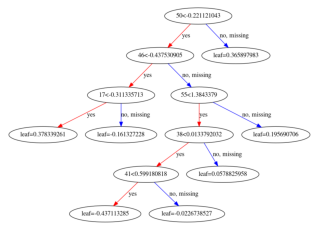

In [15]:
# here you can visualise a tree and plot it (this can also be done for the sklearn functions too)
# Get a graph
graph = xgb.to_graphviz(clf, num_trees=1)

# Or get a matplotlib axis
ax = xgb.plot_tree(clf, num_trees=1)

In [16]:
# now let's predict a model with out testing set, and also look at feature importances 
y_pred = clf.predict(X_test)
display(accuracy_score(y_test, y_pred))

# and let's explore some of the attributes, feel free to check more!
clf.feature_importances_

clf.get_booster

0.8536585365853658

<bound method XGBModel.get_booster of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=16,
              num_parallel_tree=1, predictor='cpu_predictor', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)>

Now use the `sklearn.ensemble.GradientBoostingClassifier()` function to look at different regularisation parameters and how they affect the model. Example code is given below to create graphs of the loss function deviance in relation to the number of boosting iterations. Make sure to read the different parameters required for the object, and change the combinations given below to try and find what maximises accuracy. Maybe try a different dataset as well!

In [ ]:
constant_params = {
    "n_estimators": 500,
    "max_leaf_nodes": None,
    "max_depth": None,
    "random_state": 2,
    "min_samples_split": 5,
} 

plt.figure()
for label, color, param_setting in [
    ("No shrinkage", "orange", {"learning_rate": 1.0, "subsample": 1.0}),
    ("learning_rate=0.2", "turquoise", {"learning_rate": 0.2, "subsample": 1.0}),
    ("subsample=0.5", "blue", {"learning_rate": 1.0, "subsample": 0.5}),
    ("learning_rate=0.2, subsample=0.5","gray",{"learning_rate": 0.2, "subsample": 0.5}),
    ("learning_rate=0.2, max_features=2", "magenta",{"learning_rate": 0.2, "max_features": 2})
]:
    params = dict(constant_params)
    params.update(param_setting)

    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    # compute test set deviance
    test_deviance = np.zeros((params["n_estimators"],), dtype=np.float64)

    for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
        test_deviance[i] = clf.loss_(y_test, y_pred)

    sns.lineplot(
        x=(np.arange(test_deviance.shape[0]) + 1)[::5],
        y=test_deviance[::5],
#         "-",
        color=color,
        label=label,
    )

plt.legend(loc="upper left")
plt.xlabel("Boosting Iterations")
plt.ylabel("Test Set Deviance")

plt.show()

# Your turn... Random Forest Regression!

Now that you have learned about random forests and decision trees in a classification setting, try to repeat some or all of the steps for regression models. Make sure to select the right metrics!